# Leopard detection

In this notebook we are going to train a YOLOv5 model using the [official YOLOv5](https://github.com/ultralytics/yolov5) 🚀 notebook by Ultralytics.

[Here](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb) is the original colab notebook with the tutorial. We've used the code from there to train our leopard detection model.

# Step 1: Setup

We will first install YOLOv5 and load our drive to have access to the leopard datasets.

In [1]:
# Install dependencies
!pip install requests==2.23.0
!pip install folium==0.2.1
!pip install imgaug==0.2.5
!pip install imgaug==0.2.5
!pip install chardet==4.0.0
!pip install urllib3==1.26.6
!pip install albumentations==1.0.3
# !pip install wandb
!pip install roboflow
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.9 MB/s 
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
  Attempting uninstall: requests
    Found existing installation: requests 2.28.0
    Uninstalling requests-2.28.0:
      Successfully uninstalled requests-2.28.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 0.2.4 requires chardet==4.0.0, but you have chardet 3.0.4 which

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install



fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [18]:
# Import packages

import torch
import utils
import os
import shutil
display = utils.notebook_init()  # checks

import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image, display
import glob

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 41.7/166.8 GB disk)


In [4]:
# Load the drive to access the images and annotations
from google.colab import drive
drive.mount('/content/gdrive')

# reduce the path of the drive
def driveSymboLink():
  # this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  # !ls /mydrive

driveSymboLink()

Mounted at /content/gdrive


In [4]:
# define the WDIR from your gdrive to the project Animal Re-Identification
WDIR = '/content/gdrive/MyDrive/MIDS/W210/Animal_Identification'

Check the Colab environment

In [5]:
from IPython.display import Image  # for displaying images

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Prepare the dataset

In [6]:
# not in use right now

from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [7]:
# set up environment
os.environ["DATASET_DIRECTORY"] = WDIR+"/datasets"

# data yaml file
dataPath=WDIR+'/yolov5/data/custom.yaml'


# Train the model

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data $dataPath --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/yolov5/data/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-252-g6a67594 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, io

In [ ]:
# Save the results to the drive
shutil.copytree('/content/yolov5/runs', WDIR+'/detection/runs')

'/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/detection/runs'

# Load a model

Make sure you have the latests weights in the yolov5 folder.

In [8]:
weightsPath= WDIR+'/detection/runs'
yoloPath='/content/yolov5/runs'

# Copy model from drive
shutil.copytree(WDIR+'/detection/runs', yoloPath)

'/content/yolov5/runs'

# Evaluate the model

In [8]:
WEIGHTS_TRAINED='/content/yolov5/runs/train/exp4/weights/best.pt'
SRC_DEV='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/images'

## Option A: run inference from command line

In [11]:
!python detect.py --weights $WEIGHTS_TRAINED --img 416 --conf 0.1 --source $SRC_DEV --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
image 1/905 /content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/images/giraffe_000000000063.jpg: 288x416 Done. (0.012s)
image 2/905 /content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/images/giraffe_000000000067.jpg: 288x416 Done. (0

## Obtion B: Run inference in loading torch model.

To load the model and collect the results, we need to load the model as a torch tensor. We have our model in this local machine.

In [9]:
# Model
model = torch.hub.load('/content/yolov5', 'custom', path=WEIGHTS_TRAINED, source='local') #local repo

# Inference settings
model.conf=0.1
model.max_det=1000

# Other settings
# iou = 0.45  # NMS IoU threshold
# agnostic = False  # NMS class-agnostic
# multi_label = False  # NMS multiple labels per box
# classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
# max_det = 1000  # maximum number of detections per image
# amp = False  # Automatic Mixed Precision (AMP) inference


YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


# Get the results

In [12]:
DET_PATH='/content/yolov5/runs/detect/exp4'
imgs = [DET_PATH+'/'+f for f in os.listdir(DET_PATH)]

In [10]:
# Run inference in the dev set


results=model(imgs, size=416)
results.save()


Saved 905 images to runs/detect/exp4


In [13]:
img_name = [f for f in os.listdir(DET_PATH)]
# print(img_name[400:405])

In [14]:

dfUpdated = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name', 'true'])

for ix,result in enumerate(results.pandas().xyxy):
  # print(result)
  if len(result)==0:
    result.loc[len(result)]=[0, 0, 0, 0, 1, None, 'bg']
    # print(result)
  result['true']=img_name[ix][0]
  result['file']=img_name[ix]
  # print(result)
  dfUpdated=dfUpdated.append(result)

dfUpdated = dfUpdated.reset_index()

    

In [15]:
dfUpdated['pred'] = dfUpdated['name'].apply(lambda x: x[0])


## Check the confusion matrix

In [16]:
cfMatrix=confusion_matrix( dfUpdated['true'], dfUpdated['pred'])  

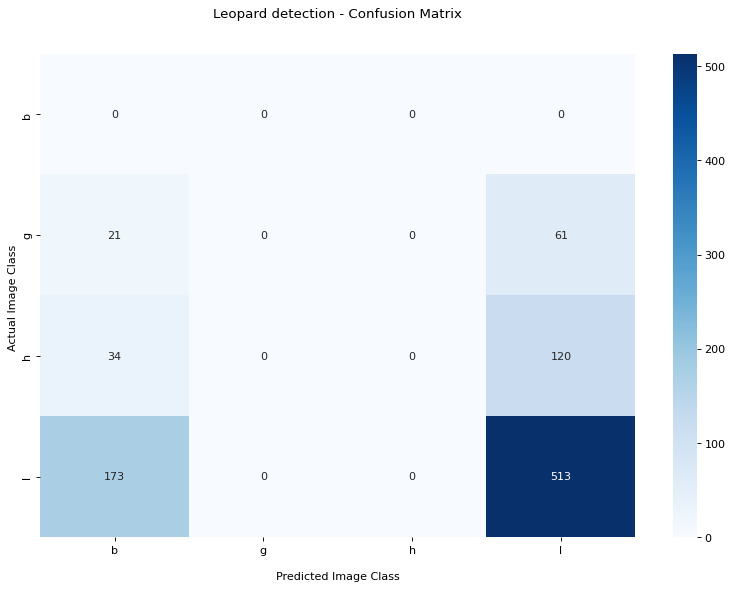

In [19]:
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.heatmap(cfMatrix, annot=True, cmap='Blues',fmt='g')
ax.set_title('Leopard detection - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Image Class')
ax.set_ylabel('Actual Image Class ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['b','g', 'h','l'])
ax.yaxis.set_ticklabels(['b','g', 'h','l'])
## Display the visualization of the Confusion Matrix.
plt.show()

Find all the giraffes and hyenas confused with leopards.

In [20]:
dfUpdated[((dfUpdated.true=='g') | (dfUpdated.true=='h')) & (dfUpdated.pred=='l')]

,index,xmin,ymin,xmax,ymax,...,class,name,true,file,pred
71,0,1163.581421,931.4505,1519.018555,1068.380371,...,0,leopard,h,hyena_000000002822.jpg,l
241,0,611.508972,208.553528,2396.246826,1800.0,...,0,leopard,h,hyena_000000000061.jpg,l
246,0,1029.489868,745.544373,2151.550049,1320.977417,...,0,leopard,g,giraffe_000000001111.jpg,l
253,0,989.166809,922.421631,1584.445801,1408.276489,...,0,leopard,g,giraffe_000000001727.jpg,l
254,0,0.0,352.090576,2058.763916,1568.665771,...,0,leopard,h,hyena_000000002786.jpg,l
...,...,...,...,...,...,...,...,...,...,...,...
897,0,391.134491,794.557678,703.3302,1377.15564,...,0,leopard,g,giraffe_000000002239.jpg,l
902,0,719.286377,589.976624,1932.308472,1231.720581,...,0,leopard,h,hyena_000000001421.jpg,l
905,0,1037.50647,1052.937744,1418.115479,1695.4021,...,0,leopard,g,giraffe_000000001696.jpg,l
910,0,577.947754,521.236084,1026.802002,1124.915527,...,0,leopard,g,giraffe_000000004912.jpg,l


In [99]:
# index_value=dfUpdated[(dfUpdated.true=='g' ) & (dfUpdated.pred=='l')].index[0]
# g_result=model(imgs[index_value])
# g_result.print()
# g_result.save()


image 1/1: 2000x3000 (no detections)
Speed: 132.9ms pre-process, 11.2ms inference, 0.5ms NMS per image at shape (1, 3, 448, 640)


In [21]:
index_value=dfUpdated[((dfUpdated.true=='g') | (dfUpdated.true=='h')) & (dfUpdated.pred=='l')].index.values
confused_imgs = [imgs[i] for i in index_value]
# print(confused_imgs)
# gh_result=model(confused_imgs)
# gh_result.save()

IndexError: ignored

In [118]:
# gh_result.print()

image 1/9: 2000x3000 (no detections)
image 2/9: 2400x2396 (no detections)
image 3/9: 1800x2400 2 leopards
image 4/9: 1600x2400 1 leopard
image 5/9: 1848x2400 (no detections)
image 6/9: 1600x2400 (no detections)
image 7/9: 1600x2400 (no detections)
image 8/9: 1600x2400 (no detections)
image 9/9: 1600x2400 (no detections)
Speed: 73.6ms pre-process, 4.3ms inference, 0.4ms NMS per image at shape (9, 3, 640, 640)


In [109]:
#display inference on confused giraffe/hyena dev images

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

Now all the leopards that were classified as background img.

In [110]:
dfUpdated[(dfUpdated.true=='l') & ((dfUpdated.pred=='h') | (dfUpdated.pred=='g') | (dfUpdated.pred=='b'))]

,index,xmin,ymin,xmax,ymax,...,class,name,true,file,pred
397,0,0,0,0,0,...,None,bg,l,leop_25_001656.jpg,b
404,0,0,0,0,0,...,None,bg,l,leop_25_001673.jpg,b
798,0,0,0,0,0,...,None,bg,l,leop_248_005675.jpg,b


In [111]:
index_value=dfUpdated[(dfUpdated.true=='l') & ((dfUpdated.pred=='h') | (dfUpdated.pred=='g') | (dfUpdated.pred=='b'))].index.values
confused_imgs = [imgs[i] for i in index_value]
# print(confused_imgs)
lb_result=model(confused_imgs)
lb_result.save()

Saved 3 images to runs/detect/exp3


In [112]:
#display inference on confused leopard background dev images

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

In [115]:
dfUpdated[dfUpdated.file=='leop_25_001656.jpg']

,index,xmin,ymin,xmax,ymax,...,class,name,true,file,pred
397,0,0,0,0,0,...,None,bg,l,leop_25_001656.jpg,b


In [116]:
len(results.pandas().xyxy)

905

In [117]:
len(imgs)

905